# Introduction
A rough guide to using the python to visualize and analyze [rawopint.lua](https://github.com/reyalpchdk/chdkscripts/tree/main/src/rawopint) logs. This notebook is intended to provide some explanation and examples using a sample log file included in the repo. To analyze your own log files, it is likely more convenient to start from `tools/rawopint-analysis.ipynb` which doesn't have the explanatory text blocks or references specific to the sample file.

# The library
The `tools/rawopint_log_plot.py` module provides the class `RawOpDataPlot`, which allows you to load, access and plot fields from a rawopint log file. It is derived from `RawOpData` in `tools/rawopint_log_analisys.py`, which implements methods that do not depend on [matplotlib](https://matplotlib.org).

In [1]:
from rawopint_log_plot import RawOpDataPlot

# Misc configuration
The `%matplotlib widget` [magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-matplotlib) below allows interactive zoom, mouse hover info and toggling data series, but is commented out here to allow the notebook to be rendered offline. Uncommenting is highly recommended if you're running the notebook locally and have the requisite `ipympl` package available.

The figsize adjust command adjusts the default size of plots to something reasonable for desktop browser window. Comment out or adjust to taste.

In [2]:
#widget provides interactive zoom, but requires ipympl, doesn't export
# %matplotlib widget
# set default plot size to something reasonable for full size browser window
import matplotlib.pyplot as plt
plt.rc('figure',figsize=(9,6),dpi=100)


# Loading data
`RawOpDataPlot.load_csv` returns an array of RawOpDataPlot objects, each representing a single run, identified by rows consisting of the CSV header, followed by one or more shots. A rawopint CSV will can contain multiple runs if the log mode is set to append. The code below loads the a sample file which contains 3 runs and displays information about each.

`RawOpDataPlot.summary` outputs a human readable summary of camera information, CHDK information and script settings.

For covenience in the examples below, the first run is assigned to a variable `r0`

In [3]:
runs=RawOpDataPlot.load_csv('../scriptlogs/rawopint-026-sample1.csv')
print(f'Loaded {len(runs)} runs')
for i, run in enumerate(runs):
    print(f'\nRun {i}')
    run.summary()
    
r0=runs[0]

Loaded 3 runs

Run 0
ixus175_elph180-100c 1.6.0-6022 rawopint 0.26-dev
60 frames, 1.0s interval, 12/12/2021 16:23:33 - 12/12/2021 16:25:08, exp# 1272 - 1331
ev_change_max: 0.333 (32) ev_shift: 0 (0) ev_use_initial: False
bv ev shift: Off
smooth factor: 0.5 limit: 0.7 rev: 0.5
over thresh: 2.0% margin: 0.25 (24)
under thresh: 10.0%  margin: 4 (384)
meter high thresh: 1 (96) limit: 1.75 (168) weight: 200
meter low thresh: -1.75 (-168) limit: -2.75 (-264) weight: 200
meter area: (center, center) 90% x 90% (212, 267) 4656 x 3496

Run 1
ixus175_elph180-100c 1.6.0-6022 rawopint 0.26-dev
60 frames, 1.0s interval, 12/12/2021 16:26:19 - 12/12/2021 16:27:54, exp# 1332 - 1391
ev_change_max: 0.333 (32) ev_shift: 0 (0) ev_use_initial: False
bv ev shift: Off
smooth factor: 0.5 limit: 0.0 rev: 0.0
over thresh: 2.0% margin: 0.25 (24)
under thresh: 10.0%  margin: 4 (384)
meter high thresh: 1 (96) limit: 1.75 (168) weight: 200
meter low thresh: -1.75 (-168) limit: -2.75 (-264) weight: 200
meter area: (c

# Data fields
Values from the CSV cells can be accessed in a variety of ways in the `RawOpData` (or `RawOpDataPlot`) object. 

`cols` is a dict of arrays for each column of the CSV, so `r0.cols['date'][0]` is the date of the first shot. Each col is available as a named property of the object, so `r0.date[0]` is equvalent to `cols['date']`.

The `cols` values only include data from rows corresponding to a shot. The initial preshoot values (corresponding to the first non-header row in the run) are stored seperately in dict `preshoot_vals`. Some script exit conditions like keyboard quit leave a partial row in the log without corresponding image. If present, values from this row are stored in `quit_vals`.

Fields from the CSV are converted to appropriate Python values, so numeric fields are integers or floats depending on the, and empty fields in numeric columns are `None`. Values in `date`,`time` and `desc` strings, and empty values in these columns are an empty string.

`init_vals` contains values parsed from the script initialization output, mostly representing script and camera settings. This can be used to query settings not described in the summary.

# Plotting data
`RawOpDataPlot` provides helper functions `plot` and `plot_group` to simplify plotting series from the CSV. Keyword arguments not recognized by these functions passed on to matplotlib [axes.plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html).

By default, in all plots, the X axis is the shot number in the run, starting at 0.

`plot` takes a column name or array of column names to plot.

`plot_group` takes a group name from one of the following pre-defined groups of related columns:
* `apex96`: Exposure related, in APEX\*96 units.
* `frac`: Over/under exposure fractions, in percent.
* `weight`: Weights representing the relative influence of meter, over and under exposure, on an arbitrary 0-200 scale
* `ev_change`: Values from the exposure change calculation representing the exposure change calculated for the next shot as well as the influence of smoothing and various limits. In APEX\*96 units, with a range of 0 - ev_change_max

When using interactive plots with `%matplotlib widget`, you can specify column values to display below the plot on hover using the `label_cols` keyword argument. Additionally, with interactive plots, series can be toggled by clicking the line in the legend.


## Plotting a single column
The following plots battery voltage, with default paramters

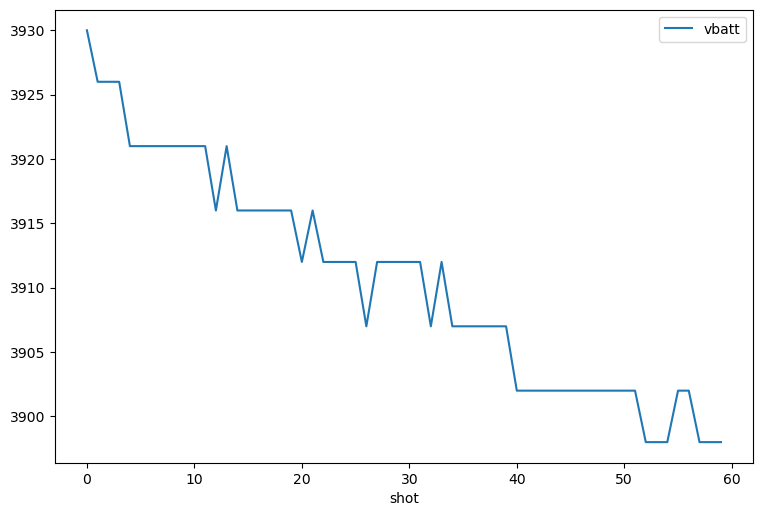

In [4]:
r0.plot('vbatt')

## Plotting exposure
The `apex96` group provides an overview of the exposure parameters and scene brightness. This is a good place to start to understand what happened in a run. In the example below, the scene starts out bright (bv high) suddenly becomes ~3 stops darker around shot 10, reaches correct exposure again around shot 20, and becomes bright again around shot 30.
 
The units are in APEX\*96, so each step of 96 represents one "stop" of exposure.

The supplied `label_cols` provide additional information on hover (requires matplotlib widget enabled) showing the image number, exposure change, and weight values.

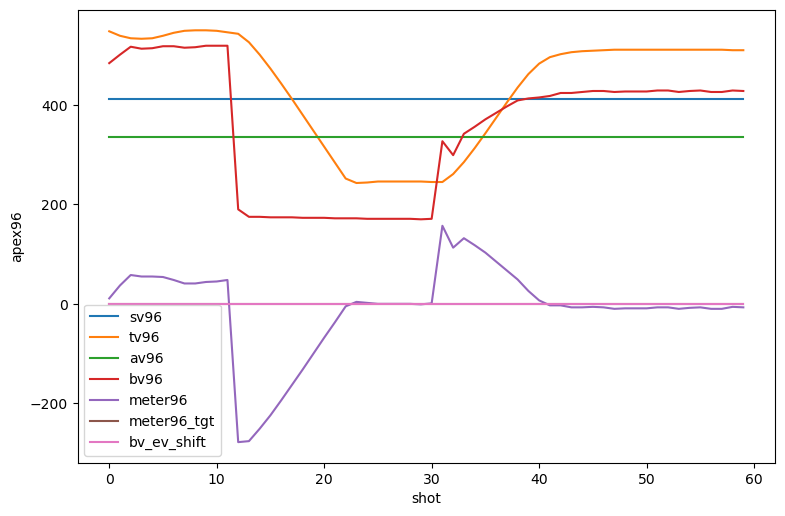

In [5]:
r0.plot_group('apex96',label_cols=['exp','d_ev','meter_weight','under_weight','over_weight'])

## Exposure change
The `ev_change` group show various stages of the exposure calculation. This shows how the exposure algorithm responded to the scene changes to produce the exposure values in the `apex96` group. The units in this group are also APEX\*96, but are limited to +/- the max_ev_change setting.

Note that some values related to smoothing are only set when the corresponding logic is active, so they can be discontinuous. Because of this, it's useful to use discrete markers rather than just lines.

Values in this plot are:
* `d_ev_base` Change calculated by the exposure algorithm prior to any smoothing. This is the amount of exposure change needed to make the next exposure equal to the target exposure, limited to +/- max_ev_change.
* `d_ev` Final, integer change after smoothing and limits. `d_ev_f` is the un-rounded, floating point version of this value.
* The remaining values are different stages of the smoothing algorithm, described in more detail in the rawopint readme.

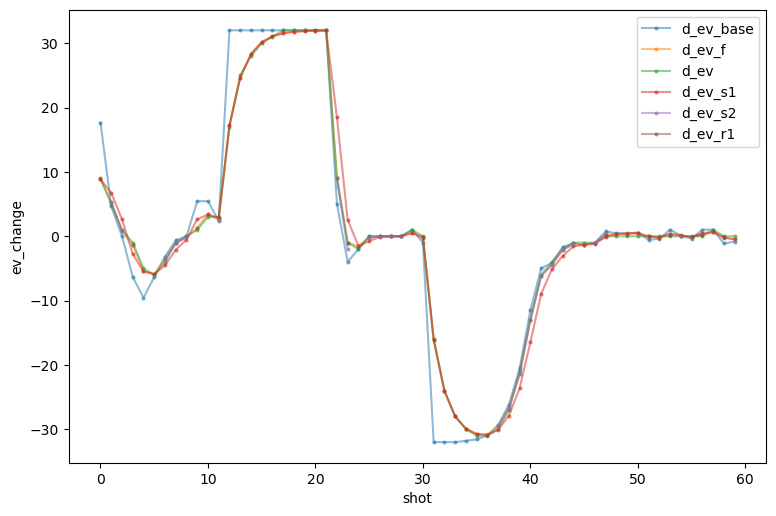

In [6]:
r0.plot_group('ev_change', alpha=0.5,markersize=4,marker='.')

## Weights
The `weight` group shows the releative influence of the meter, over and under exposure on the exposure algorithm. Weights are on an arbitrary, 0-200 scale.

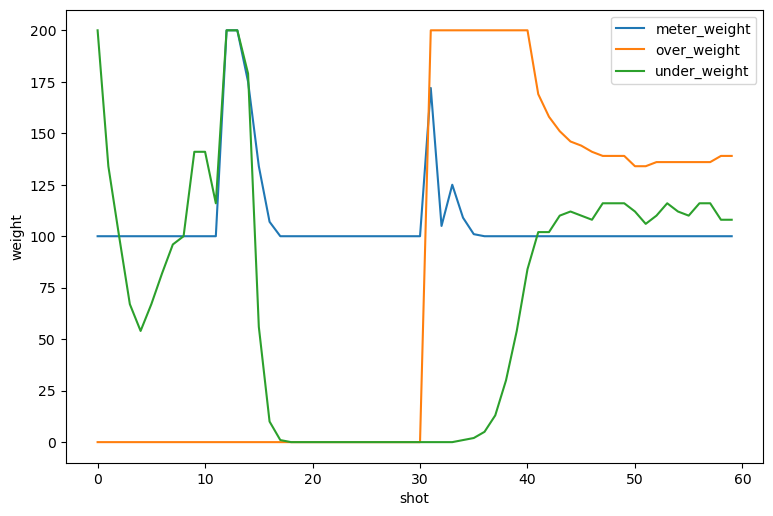

In [7]:
r0.plot_group('weight')

# Over and under exposure
The `frac` group shows the fraction of pixels outside the over exposure and under exposure limits, in percent.

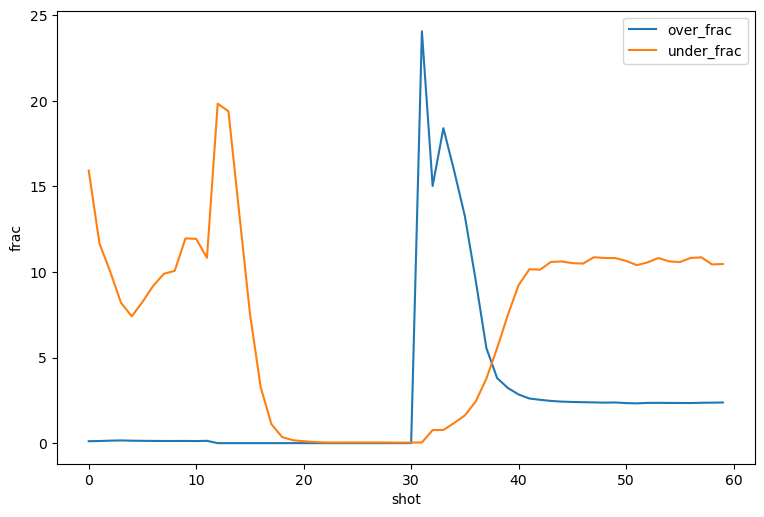

In [8]:
r0.plot_group('frac')

# Odds and ends

In [9]:
print(r0.find_max('over_frac'))
print(r0.find_max('over_weight'))

(24.049, 31, 1303)
(200, 31, 1303)


In [10]:
r0.init_vals

{'ev_change_max': 32,
 'ev_shift': 0,
 'ev_use_initial': False,
 'bv_ev_shift_pct': 0,
 'bv_ev_shift_base_bv': False,
 'tv96_long_limit': 0,
 'tv96_short_limit': 957,
 'tv96_sv_thresh': 192,
 'tv96_nd_thresh': 861,
 'nd_value': 0,
 'nd_hysteresis': 48,
 'sv96_max': 699,
 'sv96_target': 411,
 'meter_width_pct': 90,
 'meter_height_pct': 90,
 'meter_left_pct': -1,
 'meter_top_pct': -1,
 'meter_step': 15,
 'meter_high_thresh': 96,
 'meter_high_limit': 168,
 'meter_high_limit_weight': 200,
 'meter_low_thresh': -168,
 'meter_low_limit': -264,
 'meter_low_limit_weight': 200,
 'over_margin_ev': 24,
 'over_thresh_frac': 20000,
 'under_margin_ev': 384,
 'under_thresh_frac': 100000,
 'over_weight_max': 200,
 'under_weight_max': 200,
 'over_prio': 0,
 'under_prio': 0,
 'histo_step': 15,
 'do_draw': False,
 'draw_meter': 'corners',
 'draw_gauge_y_pct': 5,
 'smooth_factor': 500,
 'smooth_limit_frac': 700,
 'ev_chg_rev_limit_frac': 500,
 'meter_top': 212,
 'meter_left': 267,
 'meter_width': 4656,
 'm